In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,new_tweet_length,original_tweet_length
0,86426,@USER She should ask a few native Americans wh...,ask native americans take be,1,0,0,0,OFF,UNT,NaN,5,14
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,OFF,TIN,IND,5,11
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,19,27
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,6,11
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,8,12


# *** --changed

In [0]:
data = data[data['subtask_c'].isin(['IND'  , 'GRP' , 'OTH'])]
data.drop(columns=['subtask_a' , 'subtask_b'] , inplace = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_c
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,go home drink maga trump2020,3,2,1,1,IND
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,OTH
7,52415,@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used...,literally talk lol mass shoot like set up propaganda use divide us major issue like gun control terrorism,1,0,0,0,GRP
9,13384,@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #...,canada not need another cuck already enough looneyleft liberals f king great country qproofs trudeaumustgo,1,4,0,0,IND
12,28414,@USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL,lie corrupt traitor nobody want hear anymore lie deepstatecorruption,1,1,1,0,IND


# Splitting Data: Train and Test


In [0]:
Y = data['subtask_c']
X = data.drop(['subtask_c','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (3876, 6)
Shape of Y:  (3876,)


In [0]:
data['subtask_c'].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (2713, 6)
Shape of Y_train:  (2713,)
Shape of X_test:  (1163, 6)
Shape of Y_test:  (1163,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(IND=0, GRP=1 , OTH= 2))
Y_test = Y_test.map(dict(IND=0, GRP=1 , OTH = 2))

# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [0]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (2713, 1371)
Shape of X_test_tweet_bow  (1163, 1371)


##2. TF-IDF : Tweets

In [0]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_tweet_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_tweet_tfidf  (2713, 1371)
Shape of X_test_tweet_tfidf  (1163, 1371)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistency across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [0]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 1163/1163 [00:00<00:00, 28441.18it/s]


In [0]:
# print("Shape of X_train_tweet_avg_w2v_vectors",len(X_train_tweet_avg_w2v_vectors),len(X_train_tweet_avg_w2v_vectors[0]))
# print("Shape of X_test_tweet_avg_w2v_vectors ",len(X_test_tweet_avg_w2v_vectors),len(X_test_tweet_avg_w2v_vectors[0]))
print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (2713, 300)
Shape of X_test_tweet_avg_w2v_vectors  (1163, 300)


# Applying Naive Bayes on different featurization of Tweets

## 1. BOW



In [0]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_bow_naive =hstack((f1,f2,f3,f4,f5))
X_train_bow_naive.shape

(2713, 1375)

In [0]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_test_bow_naive =hstack((f1,f2,f3,f4,f5))
X_test_bow_naive.shape

(1163, 1375)

## Hyper Parameter Tuning: Lambda (Not needed for Naive Bayes)

## Confusion Matrix

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.6775580395528805


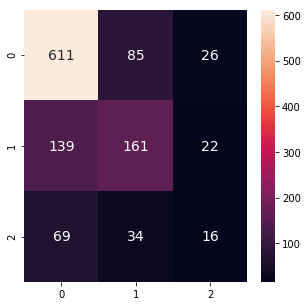

In [0]:
from sklearn.naive_bayes import GaussianNB
naive_bow = MultinomialNB()

naive_bow.fit(X_train_bow_naive.todense(),Y_train)

y_test_predict = naive_bow.predict(X_test_bow_naive.todense())

print("original size in test data : \n" , Y_test.value_counts())

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'micro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

375 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 
def prPurple(skk): print("\033[95m {}\033[00m" .format(skk)) 
def prCyan(skk): print("\033[96m {}\033[00m" .format(skk)) 
def prLighBlue(skk): print("\033[94m {}\033[00m" .format(skk)) 
def prOrange(skk): print("\033[33m {}\033[00m" .format(skk)) 

Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER After seeing the contents of the post @USER I for one are pleased with the legislation we have in regard of gun control. On the other hand legislation does need to be improved to support mental aid to this individual. He has to be sectioned.
 @USER @USER #nope... With Mm no way...maybe is time to ask Sky what has gone wrong? Because #Foster from CNN have the book first than KP tweeted about the book...  Liberals... From Trump for Americans to Mm for British... I don't known who is worst
 @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER I follow all these MAGA Patriots 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
 @USER @USER @USER @USER @USER @USER All liberals are devils. All of us. Ask any repub. We hold hands to stand together. To know we aren’t alone in this fight for civility and decency. Call us all the names you want. It doesn’t matter one bit.
 I'm Assuming I'm Not Going to Get an Answer': Brainless  #Lib

## 2. TF-IDF


In [0]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4,f5))
X_train_tfidf.shape

(2713, 1375)

In [0]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_tfidf =hstack((f1,f2,f3,f4,f5))
X_test_tfidf.shape

(1163, 1375)

## Confusion Matrix

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.6655202063628547


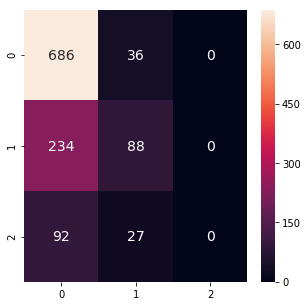

In [0]:
naive_tfidf = MultinomialNB()
naive_tfidf.fit(X_train_tfidf.todense(),Y_train)

y_test_predict = naive_tfidf.predict(X_test_tfidf.todense())

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("original size in test data : \n" , Y_test.value_counts())

print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average='micro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

389 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER After seeing the contents of the post @USER I for one are pleased with the legislation we have in regard of gun control. On the other hand legislation does need to be improved to support mental aid to this individual. He has to be sectioned.
 @USER @USER #nope... With Mm no way...maybe is time to ask Sky what has gone wrong? Because #Foster from CNN have the book first than KP tweeted about the book...  Liberals... From Trump for Americans to Mm for British... I don't known who is worst
 @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER I follow all these MAGA Patriots 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
 @USER @USER @USER @USER @USER @USER All liberals are devils. All of us. Ask any repub. We hold hands to stand together. To know we aren’t alone in this fight for civility and decency. Call us all the names you want. It doesn’t matter one bit.
 @USER But they’re still the number one Fake News Network.
 I'

## 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_w2vec =hstack((f1,f2,f3,f4,f5))
X_train_w2vec.shape

(2713, 304)

In [0]:
f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_w2vec =hstack((f1,f2,f3,f4,f5))
X_test_w2vec.shape

(1163, 304)

#### using min max scaling (0 , 1) to transform negative values

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_w2vec = scaler.fit_transform(X_train_w2vec.todense())
X_test_w2vec = scaler.transform(X_test_w2vec.todense())

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
# scaler.fit(X_train_w2vec)
# X_train_w2vec = scaler.transform(X_train_w2vec)
# X_test_w2vec = scaler.transform(X_test_w2vec)
# print(X_train_w2vec)

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.6208082545141874


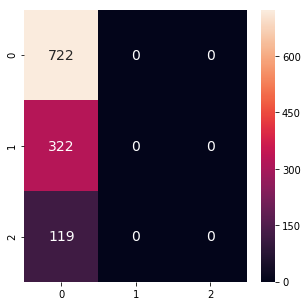

In [0]:
naive_w2vec = MultinomialNB()
naive_w2vec.fit(X_train_w2vec ,Y_train)

y_test_predict = naive_w2vec.predict(X_test_w2vec)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("original size in test data : \n" , Y_test.value_counts())
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average='micro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

441 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER After seeing the contents of the post @USER I for one are pleased with the legislation we have in regard of gun control. On the other hand legislation does need to be improved to support mental aid to this individual. He has to be sectioned.
 @USER @USER #nope... With Mm no way...maybe is time to ask Sky what has gone wrong? Because #Foster from CNN have the book first than KP tweeted about the book...  Liberals... From Trump for Americans to Mm for British... I don't known who is worst
 @USER Hate mongering is No solution for NFL KNEELERS - change up your playbook losers
 @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER I follow all these MAGA Patriots 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
 @USER @USER @USER @USER @USER @USER All liberals are devils. All of us. Ask any repub. We hold hands to stand together. To know we aren’t alone in this fight for civility and decency. Call us all the names you want. It